In [1]:
from __future__ import print_function, division
%matplotlib inline
from matplotlib import pyplot as plt
import json
import random
import numpy as np
import debiaswe as dwe
import debiaswe.we as we
from debiaswe.we import WordEmbedding
from debiaswe.debias import debias
from sklearn.decomposition import PCA

## Gender - Google News

In [2]:
# load subset of word embedding trained on Google News text
# E = WordEmbedding("./embeddings/GoogleNews-vectors-negative300-hard-debiased.bin")
E = WordEmbedding("./embeddings/w2v_gnews_small.txt")

*** Reading data from ./embeddings/w2v_gnews_small.txt
26423 words of dimension 300


In [3]:
# she−he gender direction on g2vNEWS
gender_direction = E.diff("she", "he")

# appendix A: generating analogies
gender_analogies = E.best_analogies_dist_thresh(gender_direction)

Computing neighbors
Mean: 10.2198085002
Median: 7.0


In [4]:
# print gender analogies
for (a,b,c) in gender_analogies[:20]:
# for (a,b,c) in gender_analogies:
    print(a+"-"+b)

she-he
herself-himself
her-his
woman-man
daughter-son
businesswoman-businessman
girl-boy
actress-actor
chairwoman-chairman
heroine-hero
mother-father
spokeswoman-spokesman
sister-brother
girls-boys
sisters-brothers
queen-king
niece-nephew
councilwoman-councilman
motherhood-fatherhood
women-men


In [9]:
# load professions file
with open("./data/professions.json", 'r') as f:
    professions = json.load(f)

In [6]:
# show gender bias in word vectors associated with professions
# sort by projection score in the direction of gender
# equivalent to Fig 1
gender_bias_projection_score = sorted([(E.v(w).dot(gender_direction), w) for w in professions])

print('Extreme she occupations')
print(gender_bias_projection_score[-20:])

print('\n\nExtreme he occupations')
print(gender_bias_projection_score[0:20])

Extreme she occupations
[(0.19714224, u'interior_designer'), (0.20833439, u'housekeeper'), (0.21560374, u'stylist'), (0.22363169, u'bookkeeper'), (0.23776127, u'maid'), (0.24125953, u'nun'), (0.24782579, u'nanny'), (0.24929333, u'hairdresser'), (0.24946159, u'paralegal'), (0.25276464, u'ballerina'), (0.2571882, u'socialite'), (0.26647124, u'librarian'), (0.27317625, u'receptionist'), (0.27540293, u'waitress'), (0.28085968, u'nurse'), (0.30426234, u'registered_nurse'), (0.3043797, u'homemaker'), (0.34036589, u'housewife'), (0.3523514, u'actress'), (0.35965407, u'businesswoman')]


Extreme he occupations
[(-0.23798442, u'maestro'), (-0.21665451, u'statesman'), (-0.20758669, u'skipper'), (-0.20267203, u'protege'), (-0.20206758, u'businessman'), (-0.19492392, u'sportsman'), (-0.18836351, u'philosopher'), (-0.18073659, u'marksman'), (-0.17289859, u'captain'), (-0.16785556, u'architect'), (-0.16702037, u'financier'), (-0.16313638, u'warrior'), (-0.15280862, u'major_leaguer'), (-0.15001443, u

### 5.2 direct bias

In [7]:
# direct bias
# identify gender-neutral words
with open('./data/gnews_gender/definitional_pairs.json', "r") as f:
    definitional_gender_gnews = json.load(f)

In [8]:
vector_differences_gender_gnews = []
for a, b in definitional_gender_gnews:
    center = (E.v(a) + E.v(b))/2
    vector_differences_gender_gnews.append(E.v(a) - center)
    vector_differences_gender_gnews.append(E.v(b) - center)
vector_differences_gender_gnews = np.array(vector_differences_gender_gnews)

In [9]:
pca_gender_gnews = PCA(n_components=10)
result = pca_gender_gnews.fit_transform(vector_differences_gender_gnews)

<BarContainer object of 10 artists>

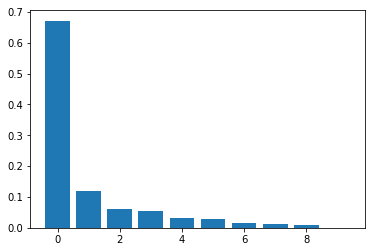

In [10]:
plt.bar(range(result.shape[1]),pca_gender_gnews.explained_variance_ratio_)

### 5.3 indirect bias

In [11]:
# plot created using R 
# export "gender_bias_projection_score" as file

# library(ggplot2)
# library(ggrepel)

# small_set <- read.table("~/Documents/berkeley/W266/w266-2018-summer-final-biased-word-embeddings/r-plots/data/gender_profession_subset-5.3.txt", header = F, stringsAsFactors = F)
# gender_bias_projection_score <- read.csv("~/Documents/berkeley/W266/w266-2018-summer-final-biased-word-embeddings/r-plots/data/gender_bias_projection_score-5.3.txt", header = F, stringsAsFactors = F )
# gender_bias_projection_score <- subset(gender_bias_projection_score, V2 %in% small_set$V1)
# png('~/Documents/berkeley/W266/w266-2018-summer-final-biased-word-embeddings/r-plots/plots/gender_bias_projection_score-5.3.png', units="in", width=4, height=2.6, res=500)
# ggplot(data = gender_bias_projection_score, aes(x = -(V1), y = 0)) +
#   geom_vline(xintercept = 0, size=0.2, linetype = "dashed", colour = "red") +
#   geom_text(aes(x = -(max(V1))+((max(V1)/4)), y = 0, label = 'extreme "she" occupations'), hjust = 1, size = 1, color = "red") +
#   geom_text(aes(x = -(min(V1)), y = 0, label = 'extreme "he" occupations'), hjust = 1, size = 1, color = "red") +
#   geom_text_repel(aes(label = V2), direction = "y", size=1.5,
#                   box.padding = unit(0.1, "lines"),
#                   color = "black", segment.alpha=0) +
#   theme_bw() +
#   theme(axis.title.y=element_blank(),
#         axis.text.y=element_blank(),
#         axis.ticks.y=element_blank(),
#         axis.title.x=element_blank(),
#         axis.text.x=element_blank(),
#         axis.ticks.x=element_blank(),
#         panel.grid.major = element_blank(),
#         panel.grid.minor = element_blank(),
#         panel.border = element_blank(),
#         panel.background = element_blank(),
#         legend.position="none"
#   )
# dev.off()   


![caption](./r-plots/plots/gender_bias_projection_score-5.3.png)

### 6 debiasing algorithm

In [16]:
# Determining gender neutral words
with open('./data/gnews_gender/equalize_pairs.json', "r") as f:
    equalize_gender_gnews = json.load(f)

with open('./data/gnews_gender/gender_specific_seed.json', "r") as f:
    gender_specific_gender_gnews = json.load(f)

In [13]:
# perform debiasing
debias(E, gender_specific_gender_gnews, definitional_gender_gnews, equalize_gender_gnews)

26423 words of dimension 300
26423 words of dimension 300


### 8 debiasing results

In [14]:
# check again for gender bias in professions after debiasing
gender_debiased_projection_score = sorted([(E.v(w).dot(gender_direction), w) for w in professions])

print('Extreme she occupations')
print(gender_debiased_projection_score[-20:])

print('\n\nExtreme he occupations')
print(gender_debiased_projection_score[0:20])

Extreme she occupations
[(0.033466972, u'drummer'), (0.033643764, u'student'), (0.034035705, u'illustrator'), (0.034525327, u'patrolman'), (0.034747459, u'hairdresser'), (0.037651747, u'foreman'), (0.037722327, u'carpenter'), (0.037771177, u'pastor'), (0.038419813, u'nanny'), (0.038888887, u'teenager'), (0.040513169, u'janitor'), (0.043088194, u'firefighter'), (0.047822051, u'wrestler'), (0.2377613, u'maid'), (0.24125955, u'nun'), (0.25276467, u'ballerina'), (0.27540293, u'waitress'), (0.34036583, u'housewife'), (0.3523514, u'actress'), (0.40583247, u'businesswoman')]


Extreme he occupations
[(-0.41548821, u'congressman'), (-0.41158709, u'businessman'), (-0.32975566, u'councilman'), (-0.29978153, u'dad'), (-0.21665451, u'statesman'), (-0.11345413, u'salesman'), (-0.073004857, u'monk'), (-0.072163939, u'handyman'), (-0.041478299, u'commander'), (-0.040511761, u'minister'), (-0.037369266, u'skipper'), (-0.036916204, u'commissioner'), (-0.033430077, u'observer'), (-0.032828867, u'manager

### verify debias by word projection on x axis

In [ ]:
# plot created using R 
# export "gender_debiased_projection_score" as file

# library(ggplot2)
# library(ggrepel)

# small_set <- read.table("~/Documents/berkeley/W266/w266-2018-summer-final-biased-word-embeddings/r-plots/data/gender_profession_subset-5.3.txt", header = F, stringsAsFactors = F)
# gender_debiased_projection_score <- read.csv("~/Documents/berkeley/W266/w266-2018-summer-final-biased-word-embeddings/r-plots/data/gender_debiased_projection_score-5.3.txt", header = F)
# gender_debiased_projection_score <- subset(gender_debiased_projection_score, V2 %in% small_set$V1)
# png('~/Documents/berkeley/W266/w266-2018-summer-final-biased-word-embeddings/r-plots/plots/gender_debiased_projection_score-5.3.png', units="in", width=4, height=2.6, res=500)
# ggplot(data = gender_debiased_projection_score, aes(x = -(V1), y = 0)) +
#   geom_vline(xintercept = 0, size=0.2, linetype = "dashed", colour = "red") +
#   geom_text(aes(x = -(max(V1))+((max(V1)/4)), y = 0, label = 'extreme "she" occupations'), hjust = 1, size = 1, color = "red") +
#   geom_text(aes(x = -(min(V1)), y = 0, label = 'extreme "he" occupations'), hjust = 1, size = 1, color = "red") +
#   geom_text_repel(aes(label = V2), direction = "y", size=1.2,
#                   box.padding = unit(0.15, "lines"),
#                   color = "black", segment.alpha=0) +
#   theme_bw() +
#   theme(axis.title.y=element_blank(),
#         axis.text.y=element_blank(),
#         axis.ticks.y=element_blank(),
#         axis.title.x=element_blank(),
#         axis.text.x=element_blank(),
#         axis.ticks.x=element_blank(),
#         panel.grid.major = element_blank(),
#         panel.grid.minor = element_blank(),
#         panel.border = element_blank(),
#         panel.background = element_blank(),
#         legend.position="none"
#   )
# dev.off()  


![caption](./r-plots/plots/gender_debiased_projection_score-5.3.png)

## Political - Google News

In [5]:
# reload "biased" Google News embeddings
E = WordEmbedding("./embeddings/w2v_gnews_small.txt")

*** Reading data from ./embeddings/w2v_gnews_small.txt
26423 words of dimension 300


In [6]:
# she−he gender direction on g2vNEWS
politics_direction_gnews = E.diff("democrats", "republicans")

# appendix A: generating analogies
politics_analogies_gnews = E.best_analogies_dist_thresh(politics_direction_gnews)

Computing neighbors
Mean: 10.2198085002
Median: 7.0


In [7]:
# print analogies
for (a,b,c) in politics_analogies_gnews[:20]:
    print(a+"-"+b)

democrats-republicans
democrat-republican
cafe-pub
federalism-devolution
cafes-pubs
democracy-peace
sects-sectarian
lawyer-solicitor
ruler-monarch
mutation-genetic
democratic-peaceful
reformers-hard_liners
militias-paramilitaries
son-dad
pluralism-multiculturalism
nationalism-nationalists
Aisha-Keisha
bloc-eurozone
Emily-Mary
expats-holidaymakers


In [10]:
# show gender bias in word vectors associated with professions
# sort by projection score in the direction of gender
# equivalent to Fig 1
political_bias_projection_score = sorted([(E.v(w).dot(politics_direction_gnews), w) for w in professions])

print('Extreme she occupations')
print(political_bias_projection_score[-20:])

print('\n\nExtreme he occupations')
print(political_bias_projection_score[0:20])

Extreme she occupations
[(0.12040618, u'statesman'), (0.12197713, u'mediator'), (0.12235285, u'deputy'), (0.1242275, u'president'), (0.12576297, u'lawmaker'), (0.12671667, u'legislator'), (0.12747315, u'trumpeter'), (0.12922281, u'businessman'), (0.13203219, u'photojournalist'), (0.13724203, u'observer'), (0.13859749, u'politician'), (0.14104803, u'saxophonist'), (0.14389695, u'violinist'), (0.14713554, u'citizen'), (0.14839262, u'philosopher'), (0.15156949, u'pianist'), (0.16372921, u'sociologist'), (0.16833378, u'cellist'), (0.17439917, u'parliamentarian'), (0.1877171, u'scholar')]


Extreme he occupations
[(-0.14370619, u'constable'), (-0.13320346, u'ranger'), (-0.12543193, u'barrister'), (-0.123773, u'priest'), (-0.12223902, u'solicitor'), (-0.11973068, u'nun'), (-0.11073694, u'archbishop'), (-0.10667094, u'solicitor_general'), (-0.1001594, u'dad'), (-0.097678468, u'sheriff_deputy'), (-0.070922807, u'bishop'), (-0.070511483, u'athletic_director'), (-0.069794148, u'parishioner'), (-

In [11]:
# direct bias
with open('./data/gnews_political/definitional_pairs_political_googlenews.json', "r") as f:
    definitional_political_gnews = json.load(f)

In [12]:
vector_differences_political_gnews = []
for a, b in definitional_political_gnews:
    center = (E.v(a) + E.v(b))/2
    vector_differences_political_gnews.append(E.v(a) - center)
    vector_differences_political_gnews.append(E.v(b) - center)
vector_differences_political_gnews = np.array(vector_differences_political_gnews)

In [13]:
pca_political_gnews = PCA(n_components=10)
result_political_gnews = pca_political_gnews.fit_transform(vector_differences_political_gnews)

<BarContainer object of 10 artists>

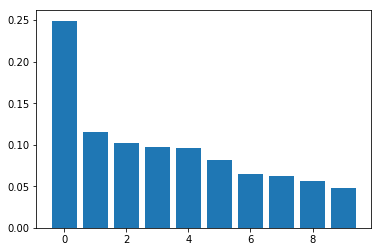

In [14]:
plt.bar(range(result_political_gnews.shape[1]),pca_political_gnews.explained_variance_ratio_)

### 5.3 indirect bias

In [21]:
# plot created using R 
# export "political_bias_projection_score" as file

# library(ggplot2)
# library(ggrepel)
# small_set <- read.table("~/Documents/berkeley/W266/w266-2018-summer-final-biased-word-embeddings/r-plots/data/political_profession_gnews_subset-5.3.txt", header = F, stringsAsFactors = F)
# political_bias_gnews_projection_score <- read.csv("~/Documents/berkeley/W266/w266-2018-summer-final-biased-word-embeddings/r-plots/data/political_bias_gnews_projection_score-5.3.txt", header = F, stringsAsFactors = F )
# political_bias_gnews_projection_score <- subset(political_bias_gnews_projection_score, V2 %in% small_set$V1)
# png('~/Documents/berkeley/W266/w266-2018-summer-final-biased-word-embeddings/r-plots/plots/political_bias_gnews_projection_score-5.3.png', units="in", width=4, height=2.6, res=500)
# ggplot(data = political_bias_gnews_projection_score, aes(x = -(V1), y = 0)) +
#   geom_vline(xintercept = 0, size=0.2, linetype = "dashed", colour = "red") +
#   geom_text(aes(x = -(max(V1))+((max(V1)/4)), y = 0, label = 'extreme "democratic" occupations'), hjust = 1, size = 1, color = "red") +
#   geom_text(aes(x = -(min(V1)), y = 0, label = 'extreme "republican" occupations'), hjust = 1, size = 1, color = "red") +
#   geom_text_repel(aes(label = V2), direction = "y", size=1.5,
#                   box.padding = unit(0.1, "lines"),
#                   color = "black", segment.alpha=0) +
#   theme_bw() +
#   theme(axis.title.y=element_blank(),
#         axis.text.y=element_blank(),
#         axis.ticks.y=element_blank(),
#         axis.title.x=element_blank(),
#         axis.text.x=element_blank(),
#         axis.ticks.x=element_blank(),
#         panel.grid.major = element_blank(),
#         panel.grid.minor = element_blank(),
#         panel.border = element_blank(),
#         panel.background = element_blank(),
#         legend.position="none"
#   )
# dev.off()  


![caption](./r-plots/plots/political_bias_gnews_projection_score-5.3.png)

### 6 debiasing algorithm

In [17]:
# Determining party neutral words
with open('./data/gnews_political/equalize_pairs_political_googlenews.json', "r") as f:
    equalize_political_gnews = json.load(f)

with open('./data/gnews_political/political_specific.json', "r") as f:
    political_specific_political_gnews = json.load(f)

In [18]:
# perform debiasing
debias(E, political_specific_political_gnews, definitional_political_gnews, equalize_political_gnews)

26423 words of dimension 300
26423 words of dimension 300


In [19]:
# check again for political bias in professions after debiasing
political_debiased_projection_score = sorted([(E.v(w).dot(politics_direction_gnews), w) for w in professions])

print('Extreme she occupations')
print(political_debiased_projection_score[-20:])

print('\n\nExtreme he occupations')
print(political_debiased_projection_score[0:20])

Extreme she occupations
[(0.048531082, u'captain'), (0.04855711, u'pollster'), (0.052678179, u'fireman'), (0.052896164, u'landlord'), (0.056234397, u'waiter'), (0.058940083, u'cellist'), (0.060230978, u'skipper'), (0.062349945, u'midfielder'), (0.063155986, u'deputy'), (0.063276008, u'ambassador'), (0.064466804, u'footballer'), (0.064846814, u'caretaker'), (0.067332596, u'goalkeeper'), (0.071969643, u'hitman'), (0.073853865, u'nanny'), (0.080945261, u'marksman'), (0.080945335, u'councilor'), (0.099750601, u'parliamentarian'), (0.27658609, u'lawyer'), (0.29726231, u'historian')]


Extreme he occupations
[(-0.33388692, u'scholar'), (-0.29611313, u'dad'), (-0.28366122, u'solicitor'), (-0.10057015, u'evangelist'), (-0.088976167, u'nun'), (-0.084431693, u'solicitor_general'), (-0.07595849, u'associate_dean'), (-0.069550283, u'publicist'), (-0.068463027, u'columnist'), (-0.068180151, u'educator'), (-0.064994715, u'saint'), (-0.060843941, u'alter_ego'), (-0.059680864, u'preacher'), (-0.059465

### verify debias by word projection on x axis

In [ ]:
# plot created using R 
# export "political_debiased_projection_score" as file

# library(ggplot2)
# library(ggrepel)
# small_set <- read.table("~/Documents/berkeley/W266/w266-2018-summer-final-biased-word-embeddings/r-plots/data/political_profession_gnews_subset-5.3.txt", header = F, stringsAsFactors = F)
# political_debiased_projection_score <- read.csv("~/Documents/berkeley/W266/w266-2018-summer-final-biased-word-embeddings/r-plots/data/political_debiased_gnews_projection_score-5.3.txt", header = F)
# political_debiased_projection_score <- subset(political_debiased_projection_score, V2 %in% small_set$V1)
# png('~/Documents/berkeley/W266/w266-2018-summer-final-biased-word-embeddings/r-plots/plots/political_debiased_projection_score-5.3.png', units="in", width=4, height=2.6, res=500)
# ggplot(data = political_debiased_projection_score, aes(x = -(V1), y = 0)) +
#   geom_vline(xintercept = 0, size=0.2, linetype = "dashed", colour = "red") +
#   geom_text(aes(x = -(max(V1))+((max(V1)/4)), y = 0, label = 'extreme "democratic" occupations'), hjust = 1, size = 1, color = "red") +
#   geom_text(aes(x = -(min(V1)), y = 0, label = 'extreme "republican" occupations'), hjust = 1, size = 1, color = "red") +
#   geom_text_repel(aes(label = V2), direction = "y", size=1.2,
#                   box.padding = unit(0.15, "lines"),
#                   color = "black", segment.alpha=0) +
#   theme_bw() +
#   theme(axis.title.y=element_blank(),
#         axis.text.y=element_blank(),
#         axis.ticks.y=element_blank(),
#         axis.title.x=element_blank(),
#         axis.text.x=element_blank(),
#         axis.ticks.x=element_blank(),
#         panel.grid.major = element_blank(),
#         panel.grid.minor = element_blank(),
#         panel.border = element_blank(),
#         panel.background = element_blank(),
#         legend.position="none"
#   )
# dev.off()  


![caption](./r-plots/plots/political_debiased_projection_score-5.3.png)

## Political - RANE

In [23]:
E2 = WordEmbedding("./embeddings/RANE_300d_english_50k.txt")

*** Reading data from ./embeddings/RANE_300d_english_50k.txt
50000 words of dimension 300
50000 words of dimension 300


In [25]:
# "democrats-republicans on RANE
political_direction_rane = E2.diff("democrats", "republicans")

# appendix A: generating analogies
political_analogies_rane = E2.best_analogies_dist_thresh(political_direction_rane)

Computing neighbors
Mean: 126.01516
Median: 26.0


In [26]:
# print gender analogies
# for (a,b,c) in politics_analogies:
for (a,b,c) in political_analogies_rane[:20]:
    print(a+'-'+b)

democrats-republicans
democratic-republican
cohesion-coherence
mores-materialism
democrat-congressman
darwinism-determinism
phobias-afflictions
civitas-ineludible
conservatism-hubris
stratification-inequalities
leveller-gatsby
outcast-anachronism
ills-maladies
networks-routers
phobia-delusions
fabric-metallic
democracy-authoritarian
psycho-slapstick
anthropology-biochemistry
outcasts-hippies


In [27]:
# load professions file for RANE embeddings
with open("./data/professions_jenni.json", 'r') as f:
    professions_rane = json.load(f)

In [28]:
political_bias_rane_projection_score = sorted([(E2.v(w).dot(political_direction_rane), w) for w in professions_rane])

print('Extreme democrats occupations')
print(political_bias_rane_projection_score[-20:])

print('\n\nExtreme republicans occupations')
print(political_bias_rane_projection_score[0:20])

Extreme democrats occupations
[(0.12082663, u'statesman'), (0.12266756, u'advocate'), (0.12300631, u'prosecutor'), (0.12386417, u'councilor'), (0.12693208, u'artist'), (0.12819286, u'researcher'), (0.12829801, u'campaigner'), (0.13046439, u'citizen'), (0.14091158, u'bishop'), (0.14352775, u'minister'), (0.14783715, u'sociologist'), (0.14796092, u'butler'), (0.15273172, u'parliamentarian'), (0.15324928, u'scientist'), (0.15771252, u'chancellor'), (0.16413482, u'pollster'), (0.17110509, u'ambassador'), (0.17263769, u'psychologist'), (0.17882782, u'broadcaster'), (0.19477884, u'worker')]


Extreme republicans occupations
[(-0.11571369, u'salesman'), (-0.091360122, u'patrolman'), (-0.085870691, u'surveyor'), (-0.083656095, u'bureaucrat'), (-0.078200363, u'parishioner'), (-0.076154895, u'banker'), (-0.075789444, u'welder'), (-0.07322409, u'broker'), (-0.073092476, u'surgeon'), (-0.07281778, u'assassin'), (-0.070674017, u'gangster'), (-0.070326477, u'negotiator'), (-0.064260527, u'physician'

### 5.2 direct bias

In [29]:
# direct bias
with open('./data/rane_political/definitional_pairs_jenni.json', "r") as f:
    definitional_political_rane = json.load(f)

In [30]:
vector_differences_political_rane = []
for a, b in definitional_political_rane:
    center = (E2.v(a) + E2.v(b))/2
    vector_differences_political_rane.append(E2.v(a) - center)
    vector_differences_political_rane.append(E2.v(b) - center)
vector_differences_political_rane = np.array(vector_differences_political_rane)

In [31]:
pca_political_rane = PCA(n_components=10)
result_political_rane = pca_political_rane.fit_transform(vector_differences_political_rane)

<BarContainer object of 10 artists>

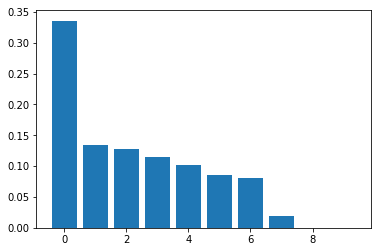

In [32]:
plt.bar(range(result_political_rane.shape[1]),pca_political_rane.explained_variance_ratio_)

### 5.3 indirect bias

In [ ]:
# plot created using R 
# export "political_bias_projection_score" as file

# library(ggplot2)
# library(ggrepel)

# small_set <- read.table("~/Documents/berkeley/W266/w266-2018-summer-final-biased-word-embeddings/r-plots/data/political_profession_rane_subset-5.3.txt", header = F, stringsAsFactors = F)
# political_bias_rane_projection_score <- read.csv("~/Documents/berkeley/W266/w266-2018-summer-final-biased-word-embeddings/r-plots/data/political_bias_rane_projection_score-5.3.txt", header = F, stringsAsFactors = F )
# political_bias_rane_projection_score <- subset(political_bias_rane_projection_score, V2 %in% small_set$V1)
# png('~/Documents/berkeley/W266/w266-2018-summer-final-biased-word-embeddings/r-plots/plots/political_bias_rane_projection_score-5.3.png', units="in", width=4, height=2.6, res=500)
# ggplot(data = political_bias_rane_projection_score, aes(x = -(V1), y = 0)) +
#   geom_vline(xintercept = 0, size=0.2, linetype = "dashed", colour = "red") +
#   geom_text(aes(x = -(max(V1))+((max(V1)/4)), y = 0, label = 'extreme "democratic" occupations'), hjust = 1, size = 1, color = "red") +
#   geom_text(aes(x = -(min(V1)), y = 0, label = 'extreme "republican" occupations'), hjust = 1, size = 1, color = "red") +
#   geom_text_repel(aes(label = V2), direction = "y", size=1.5,
#                   box.padding = unit(0.1, "lines"),
#                   color = "black", segment.alpha=0) +
#   theme_bw() +
#   theme(axis.title.y=element_blank(),
#         axis.text.y=element_blank(),
#         axis.ticks.y=element_blank(),
#         axis.title.x=element_blank(),
#         axis.text.x=element_blank(),
#         axis.ticks.x=element_blank(),
#         panel.grid.major = element_blank(),
#         panel.grid.minor = element_blank(),
#         panel.border = element_blank(),
#         panel.background = element_blank(),
#         legend.position="none"
#   )
# dev.off()  


![caption](./r-plots/plots/political_bias_rane_projection_score-5.3.png)

### 6 debiasing algorithm

In [34]:
# Determining party neutral words
with open('./data/rane_political/equalize_pairs_jenni.json', "r") as f:
    equalize_political_rane = json.load(f)

with open('./data/rane_political/political_specific.json', "r") as f:
    politics_specific_political_rane = json.load(f)

In [35]:
# perform debiasing
debias(E2, politics_specific_political_rane, definitional_political_rane, equalize_political_rane)

50000 words of dimension 300
50000 words of dimension 300


In [36]:
political_debiased_rane_projection_score = sorted([(E2.v(w).dot(political_direction_rane), w) for w in professions_rane])

print('Extreme democrats occupations')
print(political_debiased_rane_projection_score[-20:])

print('\n\nExtreme republicans occupations')
print(political_debiased_rane_projection_score[0:20])

Extreme democrats occupations
[(0.074730858, u'envoy'), (0.076328367, u'politician'), (0.077589504, u'mathematician'), (0.077779099, u'councilor'), (0.079257429, u'chancellor'), (0.079983838, u'bishop'), (0.080144882, u'prosecutor'), (0.081020989, u'firebrand'), (0.089022525, u'parliamentarian'), (0.093516253, u'protege'), (0.13662589, u'ambassador'), (0.24599895, u'artist'), (0.24748608, u'minister'), (0.27213481, u'psychologist'), (0.27941433, u'worker'), (0.29883832, u'entrepreneur'), (0.30729669, u'curator'), (0.33564091, u'senator'), (0.33989054, u'statesman'), (0.36746508, u'butler')]


Extreme republicans occupations
[(-0.34757718, u'salesman'), (-0.33389276, u'employee'), (-0.24649166, u'cardiologist'), (-0.21981466, u'painter'), (-0.19415627, u'congressman'), (-0.090159275, u'bureaucrat'), (-0.083891921, u'constable'), (-0.079088449, u'stockbroker'), (-0.073404059, u'firefighter'), (-0.068853676, u'mobster'), (-0.0675736, u'sergeant'), (-0.062459003, u'broker'), (-0.060378056,

![caption](./r-plots/plots/political_debiased_rane_projection_score-5.3.png)

## Gender - RANE

In [39]:
# reload embeddings
E2 = WordEmbedding("./embeddings/RANE_300d_english_50k.txt")

*** Reading data from ./embeddings/RANE_300d_english_50k.txt
50000 words of dimension 300
50000 words of dimension 300


In [40]:
# she−he gender direction on RANE
gender_direction_rane = E2.diff("she", "he")

# appendix A: generating analogies
gender_analogies_rane = E2.best_analogies_dist_thresh(gender_direction_rane)

Computing neighbors
Mean: 126.01516
Median: 26.0


In [41]:
# print gender analogies
for (a,b,c) in gender_analogies_rane[:20]:
    print(a+"-"+b)

she-he
herself-himself
her-his
ms-mr
businesswoman-businessman
chairwoman-chairman
woman-man
spokeswoman-spokesman
girl-boy
nora-edwin
katie-michael
mother-father
natalie-alan
marie-pierre
jennifer-gary
anastasia-nikolai
betty-gerald
captor-henchmen
begum-hasan
sisters-brothers


In [42]:
# show gender bias
gender_bias_rane_projection_score = sorted([(E2.v(w).dot(gender_direction_rane), w) for w in professions_rane])

print('Extreme she occupations')
print(gender_bias_rane_projection_score[-20:])

print('\n\nExtreme he occupations')
print(gender_bias_rane_projection_score[0:20])

Extreme she occupations
[(0.20381601, u'librarian'), (0.2091002, u'student'), (0.22505707, u'dermatologist'), (0.23889352, u'socialite'), (0.24043949, u'pediatrician'), (0.24646065, u'dancer'), (0.25038779, u'hairdresser'), (0.2578871, u'receptionist'), (0.28125584, u'homemaker'), (0.29249573, u'therapist'), (0.29351145, u'housekeeper'), (0.29729667, u'nanny'), (0.29847607, u'actress'), (0.30222109, u'businesswoman'), (0.30303526, u'waitress'), (0.33530203, u'ballerina'), (0.33843955, u'maid'), (0.34159389, u'nurse'), (0.361195, u'stylist'), (0.3793034, u'housewife')]


Extreme he occupations
[(-0.28541991, u'president'), (-0.25411597, u'businessman'), (-0.2022596, u'commander'), (-0.20182301, u'skipper'), (-0.19697638, u'midfielder'), (-0.19238442, u'tycoon'), (-0.18822497, u'protege'), (-0.17931902, u'goalkeeper'), (-0.1779283, u'captain'), (-0.17440619, u'colonel'), (-0.17219761, u'industrialist'), (-0.16733637, u'negotiator'), (-0.16285233, u'baron'), (-0.16257007, u'trader'), (-0.

### 5.2 direct bias

In [44]:
with open('./data/rane_gender/definitional_pairs_gender_rane.json') as f:
    definitional_gender_rane = json.load(f)

In [45]:
vector_differences_gender_rane = []
for a, b in definitional_gender_rane:
    center = (E2.v(a) + E2.v(b))/2
    vector_differences_gender_rane.append(E2.v(a) - center)
    vector_differences_gender_rane.append(E2.v(b) - center)
vector_differences_gender_rane = np.array(vector_differences_gender_rane)

In [46]:
pca_gender_rane = PCA(n_components=10)
result_gender_rane = pca_gender_rane.fit_transform(vector_differences_gender_rane)

<BarContainer object of 10 artists>

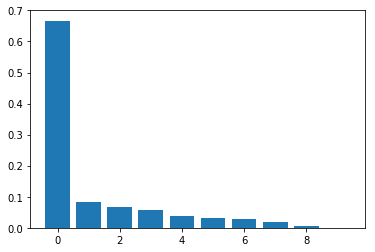

In [47]:
plt.bar(range(result_gender_rane.shape[1]),pca_gender_rane.explained_variance_ratio_)

### 5.3 indirect bias

In [ ]:
# plot created using R 
# export "gender_bias_rane_projection_score" as file

# library(ggplot2)
# library(ggrepel)
# small_set <- read.table("~/Documents/berkeley/W266/w266-2018-summer-final-biased-word-embeddings/r-plots/data/gender_profession_rane_subset-5.3.txt", header = F, stringsAsFactors = F)
# gender_bias_rane_projection_score <- read.csv("~/Documents/berkeley/W266/w266-2018-summer-final-biased-word-embeddings/r-plots/data/gender_bias_rane_projection_score-5.3.txt", header = F, stringsAsFactors = F )
# gender_bias_rane_projection_score <- subset(gender_bias_rane_projection_score, V2 %in% small_set$V1)
# png('~/Documents/berkeley/W266/w266-2018-summer-final-biased-word-embeddings/r-plots/plots/gender_bias_rane_projection_score-5.3.png', units="in", width=4, height=2.6, res=500)
# ggplot(data = gender_bias_rane_projection_score, aes(x = -(V1), y = 0)) +
#   geom_vline(xintercept = 0, size=0.2, linetype = "dashed", colour = "red") +
#   geom_text(aes(x = -(max(V1))+((max(V1)/4)), y = 0, label = 'extreme "she" occupations'), hjust = 1, size = 1, color = "red") +
#   geom_text(aes(x = -(min(V1)), y = 0, label = 'extreme "he" occupations'), hjust = 1, size = 1, color = "red") +
#   geom_text_repel(aes(label = V2), direction = "y", size=1.5,
#                   box.padding = unit(0.1, "lines"),
#                   color = "black", segment.alpha=0) +
#   theme_bw() +
#   theme(axis.title.y=element_blank(),
#         axis.text.y=element_blank(),
#         axis.ticks.y=element_blank(),
#         axis.title.x=element_blank(),
#         axis.text.x=element_blank(),
#         axis.ticks.x=element_blank(),
#         panel.grid.major = element_blank(),
#         panel.grid.minor = element_blank(),
#         panel.border = element_blank(),
#         panel.background = element_blank(),
#         legend.position="none"
#   )
# dev.off()  

![caption](./r-plots/plots/gender_bias_rane_projection_score-5.3.png)

### 6 debiasing algorithm

In [50]:
# Determining gender neutral words
with open('./data/rane_gender/equalize_pairs_gender_rane.json', "r") as f:
    equalize_gender_rane = json.load(f)

with open('./data/rane_gender/gender_specific_seed.json', "r") as f:
    gender_specific_gender_rane = json.load(f)

In [51]:
# perform debiasing
debias(E2, gender_specific_gender_rane, definitional_gender_rane, equalize_gender_rane)

50000 words of dimension 300
50000 words of dimension 300


In [53]:
gender_debiased_rane_projection_score = sorted([(E2.v(w).dot(gender_direction_rane), w) for w in professions_rane])

print('Extreme she occupations')
print(gender_debiased_rane_projection_score[-20:])

print('\n\nExtreme he occupations')
print(gender_debiased_rane_projection_score[0:20])

Extreme she occupations
[(0.045358643, u'mechanic'), (0.045674063, u'sergeant'), (0.046819601, u'detective'), (0.052570991, u'teenager'), (0.052862421, u'handyman'), (0.053542092, u'receptionist'), (0.053840935, u'butcher'), (0.054383349, u'chaplain'), (0.057192016, u'plumber'), (0.057961386, u'gardener'), (0.064178295, u'janitor'), (0.065072432, u'saint'), (0.086268082, u'dad'), (0.18554354, u'nun'), (0.29847607, u'actress'), (0.30303532, u'waitress'), (0.33530203, u'ballerina'), (0.33843955, u'maid'), (0.3793034, u'housewife'), (0.40263259, u'businesswoman')]


Extreme he occupations
[(-0.37735555, u'businessman'), (-0.31248111, u'congressman'), (-0.14984553, u'statesman'), (-0.091386236, u'salesman'), (-0.062297493, u'envoy'), (-0.053703602, u'negotiator'), (-0.046285521, u'diplomat'), (-0.045546256, u'president'), (-0.043879673, u'councilor'), (-0.032056045, u'deputy'), (-0.029436225, u'ambassador'), (-0.028291682, u'legislator'), (-0.025454696, u'firebrand'), (-0.025337283, u'prot

In [55]:
# plot created using R 
# export "gender_bias_rane_projection_score" as file

# library(ggplot2)
# library(ggrepel)
# small_set <- read.table("~/Documents/berkeley/W266/w266-2018-summer-final-biased-word-embeddings/r-plots/data/gender_profession_rane_subset-5.3.txt", header = F, stringsAsFactors = F)
# gender_debiased_projection_score <- read.csv("~/Documents/berkeley/W266/w266-2018-summer-final-biased-word-embeddings/r-plots/data/gender_debiased_projection_score-5.3.txt", header = F)
# gender_debiased_projection_score <- subset(gender_debiased_projection_score, V2 %in% small_set$V1)
# png('~/Documents/berkeley/W266/w266-2018-summer-final-biased-word-embeddings/r-plots/plots/gender_debiased_projection_score-5.3.png', units="in", width=4, height=2.6, res=500)
# ggplot(data = gender_debiased_projection_score, aes(x = -(V1), y = 0)) +
#   geom_vline(xintercept = 0, size=0.2, linetype = "dashed", colour = "red") +
#   geom_text(aes(x = -(max(V1))+((max(V1)/4)), y = 0, label = 'extreme "she" occupations'), hjust = 1, size = 1, color = "red") +
#   geom_text(aes(x = -(min(V1)), y = 0, label = 'extreme "he" occupations'), hjust = 1, size = 1, color = "red") +
#   geom_text_repel(aes(label = V2), direction = "y", size=1.2,
#                   box.padding = unit(0.15, "lines"),
#                   color = "black", segment.alpha=0) +
#   theme_bw() +
#   theme(axis.title.y=element_blank(),
#         axis.text.y=element_blank(),
#         axis.ticks.y=element_blank(),
#         axis.title.x=element_blank(),
#         axis.text.x=element_blank(),
#         axis.ticks.x=element_blank(),
#         panel.grid.major = element_blank(),
#         panel.grid.minor = element_blank(),
#         panel.border = element_blank(),
#         panel.background = element_blank(),
#         legend.position="none"
#   )
# dev.off()  


![caption](./r-plots/plots/gender_debiased_projection_score-5.3.png)